### 用 Keras 实现 DeepDream

#### 加载预训练的 Inception V3 模型

In [1]:
from keras.applications import inception_v3

from keras import backend as K

# 我们不需要训练模型，所以这个命令会禁用所有与训练有关的操作
K.set_learning_phase(0)   

# 构建不包含全连接层的 Inception V3 网络。
# 使用预训练的 ImageNet 权重来加载模型
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Using TensorFlow backend.


#### 设置 DeepDream 配置

In [2]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

#### 定义需要最大化的损失

In [3]:
# 创建一个字典，将层的名称映射为层的实例
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 在定义损失时将层的贡献添加到这个标量变量中
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output  # 获取层的输出
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 将该层特征的 L2 范数添加到 loss 中。
    # 为了避免出现边界伪影，损失中仅包含非边界的像素
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

#### 梯度上升过程

In [4]:
# 这个张量用于保存生成的图像，即梦境图像
dream = model.input

# 计算损失相对一梦境图像的梯度
grads = K.gradients(loss, dream)[0]

# 将梯度标准化，重要技巧
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 给定一张输出图像，设置一个 Keras 函数来获取损失值和梯度值
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 这个韩式运行 iterations 次梯度上升
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

#### 辅助函数

In [5]:
import scipy
import imageio
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imsave(fname, pil_img)
    

def preprocess_image(image_path):
    """通用函数，用于打开图像、改变图像大小以及
       将图像格式转换为 Inception V3 模型能够
       处理的张量
    """
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    """通用函数，将一个张量转换为有效图像"""
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # 对 inception_v3.preprocess_input 所做的
        # 预处理进行反向操作
        x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x /= 2.
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### 在多个连续尺度上运行梯度上升

In [6]:
import numpy as np

# 改变这些超参数，来得到新的效果
step = 0.01        # 梯度上升的步长
num_octave = 3     # 运行梯度上升的尺度个数
octave_scale = 1.4 # 两个尺度之间的大小比例
iterations = 20    # 在每个尺度上运行梯度上升的次数

max_loss = 10.   # 如果损失增大到10，我们要中断梯度上升过程，以避免得到丑陋的伪影

base_img_path = 'images/image2.png'

# 将基础图像加载成一个 Numpy 数组
img = preprocess_image(base_img_path)

# 准备一个由形状元组组成的列表，它定义了运行梯度上升的不同尺度
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
        for dim in original_shape])
    successive_shapes.append(shape)

# 将形状列表反转，变为升序
successive_shapes = successive_shapes[::-1]

# 将图像 Numpy 数组的大小缩放到最小尺寸
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape) # 将梦境图像放大
    # 运行梯度上升，改变梦境图像
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    # 将原始图像的较小版本放大，它会变得像素化
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    # 在这个尺寸上计算原始图像的高质量版本
    same_size_original = resize_img(original_img, shape)
    # 二者的差别就是在放大过程中丢失的细节
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    # 将丢失的细节重新注入到梦境图像中
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='images/dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='images/final_dream2.png')

Processing image shape (367, 275)
...Loss value at 0 : 1.1965485
...Loss value at 1 : 1.5466518
...Loss value at 2 : 1.990701
...Loss value at 3 : 2.5215878
...Loss value at 4 : 3.1185129
...Loss value at 5 : 3.6928864
...Loss value at 6 : 4.296027
...Loss value at 7 : 4.874691
...Loss value at 8 : 5.4917436
...Loss value at 9 : 6.060787
...Loss value at 10 : 6.621002
...Loss value at 11 : 7.2213883
...Loss value at 12 : 7.80276
...Loss value at 13 : 8.321639
...Loss value at 14 : 8.851206
...Loss value at 15 : 9.358921
...Loss value at 16 : 9.891672
Processing image shape (514, 385)
...Loss value at 0 : 3.0877655
...Loss value at 1 : 4.499219
...Loss value at 2 : 5.5987663
...Loss value at 3 : 6.552361
...Loss value at 4 : 7.4380627
...Loss value at 5 : 8.233317
...Loss value at 6 : 8.976581
...Loss value at 7 : 9.675909


D:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (720, 540)
...Loss value at 0 : 3.200319
...Loss value at 1 : 4.463497
...Loss value at 2 : 5.5054145
...Loss value at 3 : 6.480547
...Loss value at 4 : 7.384132
...Loss value at 5 : 8.228707
...Loss value at 6 : 9.006451
...Loss value at 7 : 9.770124


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

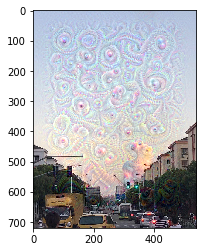

In [8]:
plt.imshow(deprocess_image(np.copy(img)))
plt.show()